# ECE 1724

Houfu Chen,

Renz Lowe,


## General *workflow* is as the following:

(colors are referring to this chart only )

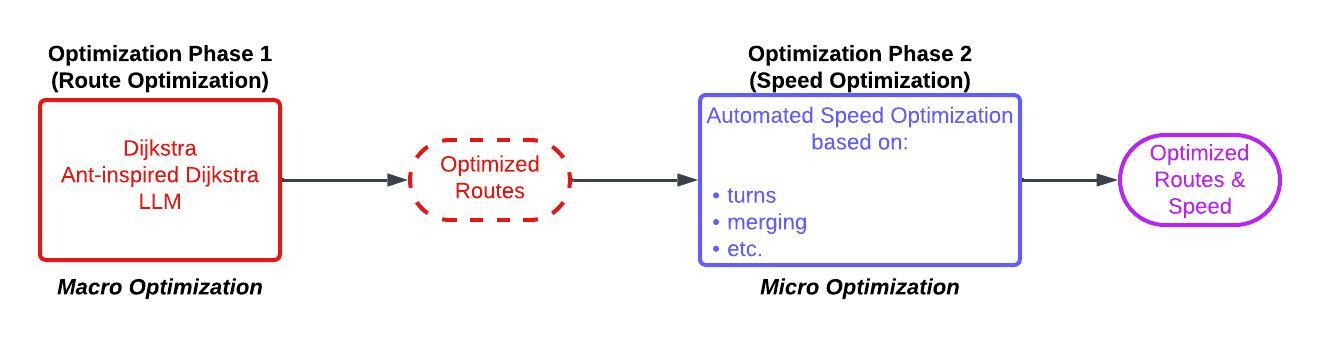

## General *Route finding algorithm(s)* is as the following:

(colors are referring to this chart only )

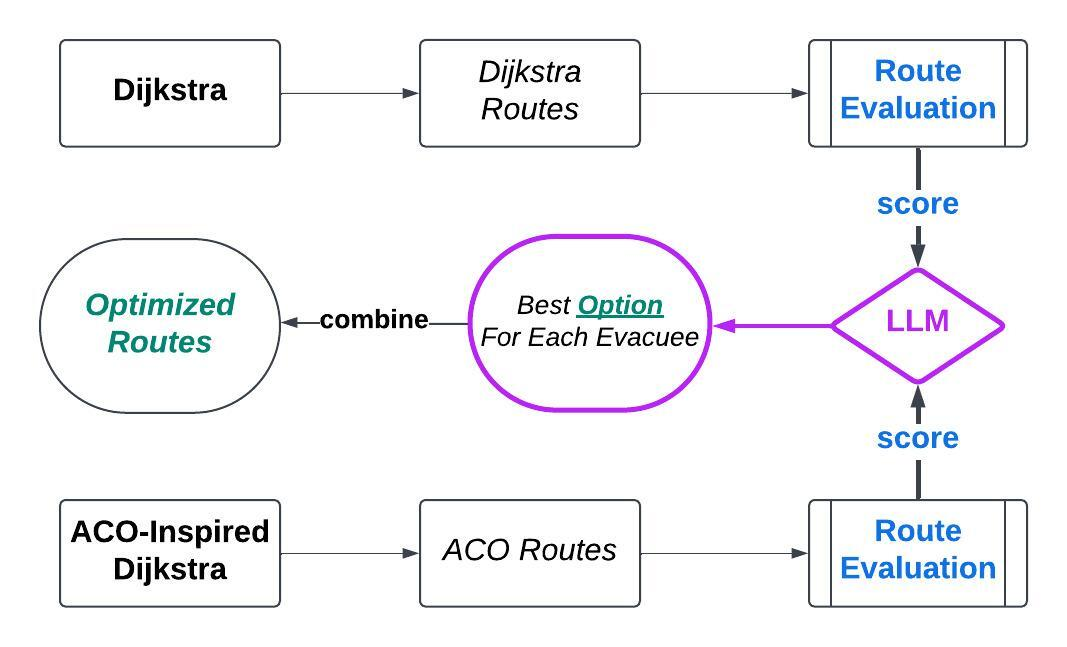

1. Input Structure:
- Define danger zone, starting points, and potential safe points.

2. LLM Integration:
- Use GPT to suggest routes and intermediate waypoints.

3. Route Validation:
- Validate LLM-suggested routes against geospatial data.
- Ensure they lead to safe points outside the danger zone.

4. Visualization:
- Plot the danger zone, routes, and safe points on a map.

5. Refinement:
- Optimize routes and animate them if needed.

In [1]:
!pip install osmnx geopandas matplotlib contextily shapely googlemaps polyline folium


In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import requests
import folium
import polyline
import math
import json
import requests
import random
from shapely.geometry import Point
import networkx as nx


In [3]:


# Replace 'your_new_api_key' with your actual API key
api_key_data = {
    "matrix_api_key": "",
    "distance_api_key": "",
    "openai_api_key": ""
}

# Save the API key in a JSON file
with open("google_api_key.json", "w") as json_file:
    json.dump(api_key_data, json_file)

print("API key saved to google_api_key.json")


# Load the API key from the JSON file
with open("google_api_key.json", "r") as json_file:
    key_data = json.load(json_file)

# Get the API key from the dictionary
API_KEY = key_data['matrix_api_key']

DIST_API_KEY = key_data['distance_api_key']

OPENAI_API_KEY = key_data['openai_api_key']

API key saved to google_api_key.json


In [4]:


def initialize_map(center_latitude, center_longitude, radius=0.05):
    """
    Initialize a Folium map centered around the disaster zone and add the disaster circle.
    """
    # Create a map centered around the disaster zone
    m = folium.Map(location=[center_latitude, center_longitude], zoom_start=14)

    # Create and add the disaster zone circle
    center_point = Point(center_longitude, center_latitude)
    disaster_zone_circle = center_point.buffer(radius)
    folium.GeoJson(disaster_zone_circle).add_to(m)

    return m

longitude = -157.8494
latitude = 21.2969

# Initialize map once
m = initialize_map(latitude, longitude, radius=0.05)
m

In [5]:
!pip install ee geemap

In [6]:
!pip install --upgrade earthengine-api geemap


import ee
import geemap

  Using cached earthengine_api-1.4.2-py3-none-any.whl.metadata (1.8 kB)
Using cached earthengine_api-1.4.2-py3-none-any.whl (457 kB)
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.4.1
    Uninstalling earthengine-api-1.4.1:
      Successfully uninstalled earthengine-api-1.4.1


In [7]:
### Fill in your own ee project code ###

ee.Authenticate()
ee.Initialize(project='')

In [8]:
# Define the AOI for Honolulu
honolulu_aoi = m.get_bounds()
# Load the GPWv4 population density dataset
population_density = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Density')

# Select the population density for the year 2020
pop_density_2020 = population_density.filter(ee.Filter.date('2020-01-01', '2020-12-31')).first()

# Clip the data to the AOI
pop_density_honolulu = pop_density_2020.clip(honolulu_aoi)


In [9]:
def assign_population_density(nodes, population_density_image):
    """
    Assign population density values to nodes.
    If a node doesn't have a valid density, it is assigned a default value of 0.
    """
    # Step 1: Create an Earth Engine FeatureCollection from all nodes
    features = [
        ee.Feature(ee.Geometry.Point(node.geometry.x, node.geometry.y))
        for idx, node in nodes.iterrows()
    ]
    nodes_fc = ee.FeatureCollection(features)

    # Step 2: Sample population density values in bulk
    sampled = population_density_image.sampleRegions(
        collection=nodes_fc,
        scale=1000
    ).getInfo()

    # Step 3: Map densities to nodes (default value = 0 for missing data)
    density_values = []
    sampled_features = sampled.get('features', [])
    for idx in range(len(nodes)):
        if idx < len(sampled_features):
            # Get density if available
            density = sampled_features[idx]['properties'].get('b1', 0)
            density_values.append(density)
        else:
            # Assign default density of 0 if no valid value
            density_values.append(0)

    # Step 4: Add densities to nodes GeoDataFrame
    nodes['density'] = density_values
    return nodes


In [10]:
def generate_random_points_inside_circle(m, center_longitude, center_latitude, population_density_image, num_points=10, radius=0.05):
    """
    Generate random evacuation points on roads within a circular disaster zone, weighted by population density.
    """
    from shapely.geometry import Point

    # Step 1: Create a circular disaster zone
    center_point = Point(center_longitude, center_latitude)
    disaster_zone_circle = center_point.buffer(radius)

    # Step 2: Load the road network around the disaster zone
    G = ox.load_graphml(filepath='honolulu.graphml')
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

    # Step 3: Filter nodes within the disaster zone
    nodes_in_zone = nodes[nodes.geometry.within(disaster_zone_circle)].copy()

    # Step 4: Assign population density to nodes
    nodes_in_zone = assign_population_density(nodes_in_zone, population_density_image)

    # Step 5: Normalize densities to create probabilities
    if nodes_in_zone['density'].sum() == 0:
        # If all densities are zero, assign equal probabilities
        nodes_in_zone['probability'] = 1 / len(nodes_in_zone)
    else:
        # Otherwise, normalize densities to create probabilities
        nodes_in_zone['probability'] = nodes_in_zone['density'] / nodes_in_zone['density'].sum()

    # Step 6: Randomly select nodes weighted by density
    selected_nodes = nodes_in_zone.sample(n=num_points, weights=nodes_in_zone['probability'], replace=True)

    # Step 7: Add selected nodes to the map
    points_inside = []
    for idx, node in selected_nodes.iterrows():
        folium.Marker(
            location=[node.geometry.y, node.geometry.x],
            icon=folium.Icon(color="red"),
            popup=f"Evacuation Point {idx} (Inside)"
        ).add_to(m)
        points_inside.append([node.geometry.y, node.geometry.x])

    return m, points_inside


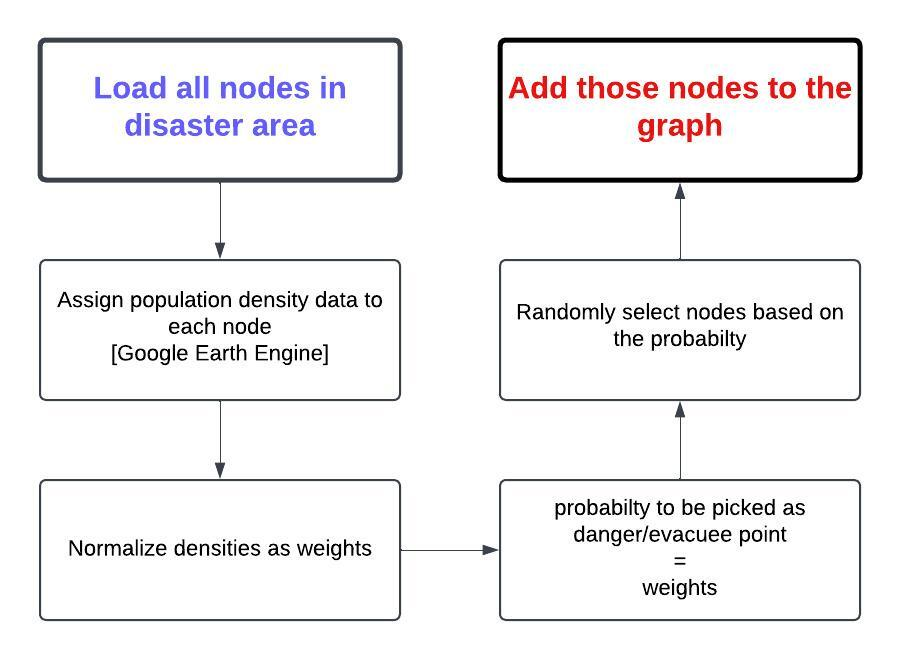

In [11]:



# Generate evacuation points
m, points_inside = generate_random_points_inside_circle(
    m,
    center_longitude=longitude,
    center_latitude=latitude,
    population_density_image=pop_density_2020,
    num_points=500,
    radius=0.05
)

# Display the map
m


In [12]:
# def generate_random_points_inside_circle(m, center_longitude, center_latitude, num_points=10, radius=0.05):
#     """
#     Generate random evacuation points on roads within a circular disaster zone.
#     """
#     # Create disaster zone circle
#     center_point = Point(center_longitude, center_latitude)
#     disaster_zone_circle = center_point.buffer(radius)

#     # Load the road network around the disaster zone
#     G = ox.load_graphml(filepath='honolulu.graphml')
#     nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

#     # Filter nodes within the disaster zone
#     nodes_in_zone = nodes[nodes.geometry.within(disaster_zone_circle)]

#     # Randomly select nodes within the disaster zone
#     selected_nodes = nodes_in_zone.sample(n=num_points)

#     points_inside = []

#     # Add selected nodes as evacuation points
#     for idx, node in selected_nodes.iterrows():
#         folium.Marker(
#             location=[node.geometry.y, node.geometry.x],
#             icon=folium.Icon(color="red"),
#             popup=f"Evacuation Point {idx} (Inside)"
#         ).add_to(m)
#         points_inside.append([node.geometry.y, node.geometry.x])

#     return m, points_inside


# # Add points inside the disaster zone to the map
# m, points_inside= generate_random_points_inside_circle(m, longitude, latitude, num_points=100, radius=0.05)

# m

In [13]:
len(points_inside)

500

In [14]:
import osmnx as ox
from shapely.geometry import Point
import folium


def generate_evacuation_points_outside_circle(
    m, center_longitude, center_latitude, num_points=5, radius=0.05, ring_width=0.01
):
    """
    Generate evacuation points just outside a circular disaster zone within a specified ring.
    """
    # Create the inner and outer circle for the ring
    center_point = Point(center_longitude, center_latitude)
    outer_circle = center_point.buffer(radius + ring_width)
    inner_circle = center_point.buffer(radius)
    evacuation_ring = outer_circle.difference(inner_circle)

    # Load road network data
    G = ox.load_graphml(filepath='honolulu.graphml')
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

    # Filter nodes within the evacuation ring
    nodes_in_ring = nodes[nodes.geometry.within(evacuation_ring)]
    if nodes_in_ring.empty:
        raise ValueError("No nodes found in the specified evacuation ring.")

    # Randomly select nodes from the evacuation ring
    selected_nodes = nodes_in_ring.sample(n=num_points)
    points_outside = []

    for idx, node in selected_nodes.iterrows():
        folium.Marker(
            location=[node.geometry.y, node.geometry.x],
            icon=folium.Icon(color="blue"),
            popup=f"Evacuation Point {idx} (Outside)",
        ).add_to(m)
        points_outside.append([node.geometry.y, node.geometry.x])

    return m, points_outside


# Disaster zone center and radius
longitude = -157.8494
latitude = 21.2969
disaster_radius = 0.05  # Disaster zone radius in degrees
ring_width = 0.01  # Width of the evacuation ring


# Generate evacuation points just outside the disaster zone
m, points_outside = generate_evacuation_points_outside_circle(
    m, longitude, latitude, num_points=100, radius=disaster_radius, ring_width=ring_width
)

# Display the map
m


Generated:

- Danger zone
- 5 Danger points (red) --> evacuees
- 3 Safe points (blue) --> shelter


In [15]:
import osmnx as ox

# Define the center point and distance for the graph
center_latitude = 21.2969  # Example latitude
center_longitude = -157.8494  # Example longitude

# Load road network around the disaster zone
G = ox.load_graphml(filepath='honolulu.graphml')


In [16]:
num_nodes = len(G.nodes)
print(f" {num_nodes} ")

图中共有 6393 个节点


## Get best route based on graph

### first make a helper function to get length/maxspeed for each edge

In [17]:
def calculate_adjusted_weight(data):
    """
    Calculate the adjusted weight of an edge based on its length and maxspeed.

    Parameters:
    - data (dict): Edge data containing 'length' and 'maxspeed'.

    Returns:
    - float: Adjusted weight for the edge.
    """
    maxspeed = data.get('maxspeed', '50 km/h')  # Default to '50 km/h' if not provided

    # Handle different formats for maxspeed
    try:
        if isinstance(maxspeed, list):
            maxspeed = maxspeed[0]  # Use the first value if maxspeed is a list
        if isinstance(maxspeed, (int, float)):  # If numeric, assume it's in km/h
            maxspeed_mps = maxspeed / 3.6  # Convert km/h to m/s
        elif isinstance(maxspeed, str):  # If string, parse it
            if 'mph' in maxspeed:
                maxspeed_mps = float(maxspeed.split()[0]) * 0.44704  # Convert mph to m/s
            elif 'km/h' in maxspeed:
                maxspeed_mps = float(maxspeed.split()[0]) / 3.6  # Convert km/h to m/s
            else:
                print(f"Unknown maxspeed format: {maxspeed}, defaulting to 50 km/h")
                maxspeed_mps = 50 / 3.6  # Default to 50 km/h
        else:
            print(f"Unknown maxspeed type: {type(maxspeed)}, defaulting to 50 km/h")
            maxspeed_mps = 50 / 3.6  # Default to 50 km/h
    except (ValueError, TypeError) as e:
        print(f"Error parsing maxspeed '{maxspeed}': {e}, defaulting to 50 km/h")
        maxspeed_mps = 50 / 3.6  # Default to 50 km/h

    # Ensure length exists
    if 'length' in data:
        return data['length'] / maxspeed_mps
    else:
        print(f"Missing 'length' attribute in edge data. Assigning infinite weight.")
        return float('inf')  # Set an infinite weight for unusable edges


In [18]:
def find_best_routes(G, start_points, end_points):
    """
    Calculate the shortest path from each start point to the nearest end point using Dijkstra's algorithm.
    """
    routes = []
    start_nodes = [ox.distance.nearest_nodes(G, point[1], point[0]) for point in start_points]
    end_nodes = [ox.distance.nearest_nodes(G, point[1], point[0]) for point in end_points]

    # Precompute adjusted weights for all edges
    for u, v, key, data in G.edges(keys=True, data=True):
        data['adjusted_weight'] = calculate_adjusted_weight(data)

    for start_node in start_nodes:
        shortest_route = None
        shortest_length = float('inf')

        for end_node in end_nodes:
            try:
                length = nx.shortest_path_length(G, start_node, end_node, weight='adjusted_weight')
                if length < shortest_length:
                    shortest_length = length
                    shortest_route = nx.shortest_path(G, start_node, end_node, weight='adjusted_weight')
            except nx.NetworkXNoPath:
                continue

        if shortest_route:
            routes.append(shortest_route)
        else:
            print(f"Warning: No route found for start node {start_node}")

    print(f"Total routes found: {len(routes)}")
    return routes



## ACO inspired Dijkstra  

1. send all points as a batch
2. calculate weight change for roads
3. update road edge weight
4. send another batch


In [19]:
# import osmnx as ox
# import networkx as nx
# from itertools import groupby


# def find_best_routes_with_pheromones_v2(
#     G, start_points, end_points, num_trials=10, decay_factor=0.95, pheromone_weight=1.0
# ):
#     """
#     Calculate the best routes iteratively using ACO-inspired logic, adjusting weights based on the shortest routes.
#     """
#     # Convert start and end points to nearest graph nodes
#     start_nodes = [ox.distance.nearest_nodes(G, point[1], point[0]) for point in start_points]
#     end_nodes = [ox.distance.nearest_nodes(G, point[1], point[0]) for point in end_points]

#     # Initialize pheromone levels on edges
#     for u, v, key, data in G.edges(keys=True, data=True):
#         data['pheromone'] = 1.0  # Initial pheromone level

#     # Define pheromone bounds
#     max_pheromone = 10.0
#     min_pheromone = 0.1

#     # Dictionary to store route lengths over trials
#     route_lengths_over_trials = {start_node: {end_node: [] for end_node in end_nodes} for start_node in start_nodes}

#     all_routes = []
#     for trial in range(num_trials):
#         print(f"\n--- Trial {trial + 1} ---")
#         trial_routes = []  # Routes for this trial

#         # Adjust edge weights to include pheromone influence before routing
#         for u, v, key, data in G.edges(keys=True, data=True):
#             # Ensure the length is in meters and calculate adjusted weight
#             if 'length' in data:
#                 data['adjusted_weight'] = data['length'] / data.get('pheromone', 1.0)
#             else:
#                 print(f"Missing 'length' attribute in edge data for edge ({u}, {v})")

#         for start_node in start_nodes:
#             for end_node in end_nodes:
#                 shortest_route = None
#                 shortest_length = float('inf')

#                 try:
#                     # Find the shortest path with the adjusted weights
#                     length = nx.shortest_path_length(G, start_node, end_node, weight='adjusted_weight')
#                     route = nx.shortest_path(G, start_node, end_node, weight='adjusted_weight')
#                     if length < shortest_length:
#                         shortest_length = length
#                         shortest_route = route
#                 except nx.NetworkXNoPath:
#                     continue

#                 if shortest_route:
#                     trial_routes.append((start_node, shortest_route, shortest_length))
#                     #print(f"Route found from {start_node} to {end_node}, Length: {shortest_length}")
#                     # Store the shortest length for this trial
#                     route_lengths_over_trials[start_node][end_node].append(shortest_length)
#                 else:
#                     print(f"Warning: No unique route found for start node {start_node} to end node {end_node}")
#                     route_lengths_over_trials[start_node][end_node].append(None)  # Log None if no route was found

#         # Update pheromone levels based on the best routes in this trial
#         for _, route, distance in trial_routes:
#             total_route_distance = distance
#             edge_list = []
#             for i in range(len(route) - 1):
#                 u = route[i]
#                 v = route[i + 1]
#                 edge_data_dict = G.get_edge_data(u, v)
#                 if edge_data_dict:
#                     # Choose the edge with the minimum length
#                     key, edge_data = min(edge_data_dict.items(), key=lambda item: item[1]['length'])
#                     edge_list.append((u, v, key))
#                 else:
#                     print(f"No edge data between {u} and {v}")
#                     continue  # Skip if no edge data

#             if total_route_distance == 0:
#                 continue  # Skip if no valid edges

#             # Update pheromone on edges
#             for u, v, key in edge_list:
#                 G[u][v][key]['pheromone'] += pheromone_weight / total_route_distance
#                 G[u][v][key]['pheromone'] = max(min_pheromone, min(max_pheromone, G[u][v][key]['pheromone']))

#         # Apply pheromone decay to all edges
#         for u, v, key, data in G.edges(keys=True, data=True):
#             data['pheromone'] = data['pheromone'] * decay_factor + 1.0 * (1 - decay_factor)
#             data['pheromone'] = max(min_pheromone, min(max_pheromone, data['pheromone']))

#         all_routes.extend(trial_routes)
#         print(f"Trial {trial + 1} completed. Routes found: {len(trial_routes)}")

#     # Select the best route for each danger point based on shortest distance
#     best_routes_per_danger_point = {}
#     for start_node, group in groupby(all_routes, key=lambda x: x[0]):
#         best_route = min(group, key=lambda x: x[2])  # Select route with the shortest length
#         best_routes_per_danger_point[start_node] = best_route[1]  # Store only the route

#     print(f"\nTotal unique routes found: {len(best_routes_per_danger_point)}")
#     return list(best_routes_per_danger_point.values()), route_lengths_over_trials


In [20]:
from itertools import groupby


## ACO- inspired Dijkstra Route Finding

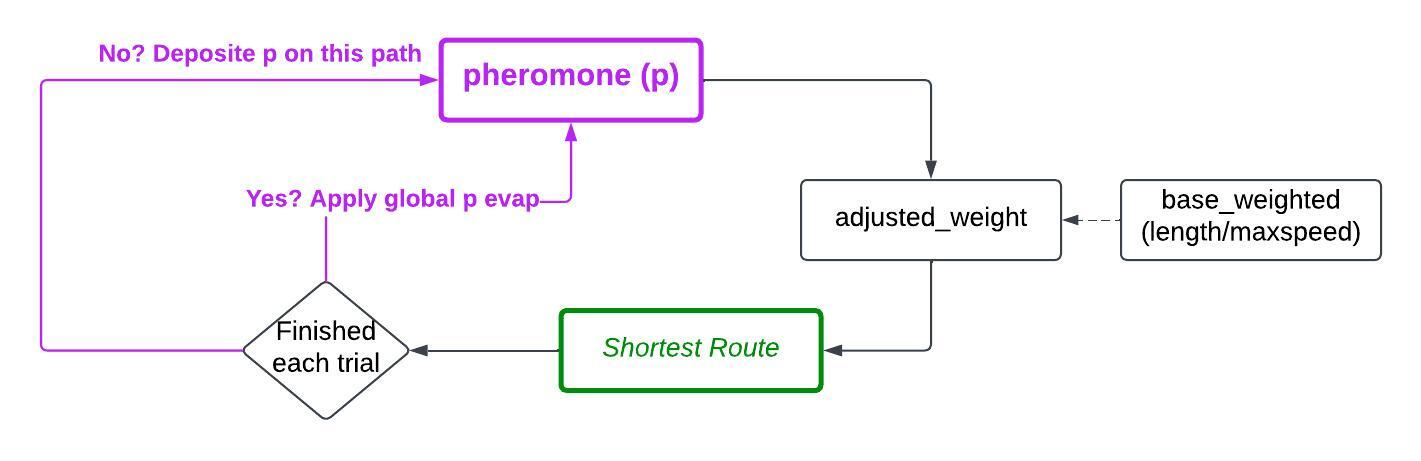

In [21]:
def find_best_routes_with_pheromones_v2(
    G, start_points, end_points, num_trials=10, decay_factor=0.95, pheromone_weight=1.0
):
    """
    Calculate the best routes iteratively using ACO-inspired logic, adjusting weights based on the shortest routes.
    """
    # Convert start and end points to nearest graph nodes
    start_nodes = [ox.distance.nearest_nodes(G, point[1], point[0]) for point in start_points]
    end_nodes = [ox.distance.nearest_nodes(G, point[1], point[0]) for point in end_points]

    # Initialize pheromone levels on edges
    for u, v, key, data in G.edges(keys=True, data=True):
        data['pheromone'] = 1.0  # Initial pheromone level

    # Define pheromone bounds
    max_pheromone = 10.0
    min_pheromone = 0.1

    # Dictionary to store route lengths over trials
    route_lengths_over_trials = {start_node: {end_node: [] for end_node in end_nodes} for start_node in start_nodes}

    all_routes = []
    for trial in range(num_trials):
        print(f"\n--- Trial {trial + 1} ---")
        trial_routes = []  # Routes for this trial

        # Adjust edge weights to include pheromone influence and adjusted weight
        for u, v, key, data in G.edges(keys=True, data=True):
            # Calculate adjusted weight using calculate_adjusted_weight
            base_weight = calculate_adjusted_weight(data)
            data['adjusted_weight'] = base_weight / data.get('pheromone', 1.0)

        for start_node in start_nodes:
            for end_node in end_nodes:
                shortest_route = None
                shortest_length = float('inf')

                try:
                    # Find the shortest path with the adjusted weights
                    length = nx.shortest_path_length(G, start_node, end_node, weight='adjusted_weight')
                    route = nx.shortest_path(G, start_node, end_node, weight='adjusted_weight')
                    if length < shortest_length:
                        shortest_length = length
                        shortest_route = route
                except nx.NetworkXNoPath:
                    continue

                if shortest_route:
                    trial_routes.append((start_node, shortest_route, shortest_length))
                    # Store the shortest length for this trial
                    route_lengths_over_trials[start_node][end_node].append(shortest_length)
                else:
                    print(f"Warning: No unique route found for start node {start_node} to end node {end_node}")
                    route_lengths_over_trials[start_node][end_node].append(None)  # Log None if no route was found

        # Update pheromone levels based on the best routes in this trial
        for _, route, distance in trial_routes:
            total_route_distance = distance
            edge_list = []
            for i in range(len(route) - 1):
                u = route[i]
                v = route[i + 1]
                edge_data_dict = G.get_edge_data(u, v)
                if edge_data_dict:
                    # Choose the edge with the minimum length
                    key, edge_data = min(edge_data_dict.items(), key=lambda item: item[1]['length'])
                    edge_list.append((u, v, key))
                else:
                    print(f"No edge data between {u} and {v}")
                    continue  # Skip if no edge data

            if total_route_distance == 0:
                continue  # Skip if no valid edges

            # Update pheromone on edges
            for u, v, key in edge_list:
                G[u][v][key]['pheromone'] += pheromone_weight / total_route_distance
                G[u][v][key]['pheromone'] = max(min_pheromone, min(max_pheromone, G[u][v][key]['pheromone']))

        # Apply pheromone decay to all edges
        for u, v, key, data in G.edges(keys=True, data=True):
            data['pheromone'] = data['pheromone'] * decay_factor + 1.0 * (1 - decay_factor)
            data['pheromone'] = max(min_pheromone, min(max_pheromone, data['pheromone']))

        all_routes.extend(trial_routes)
        print(f"Trial {trial + 1} completed. Routes found: {len(trial_routes)}")

    # Select the best route for each danger point based on adjusted weight
    best_routes_per_danger_point = {}
    for start_node, group in groupby(all_routes, key=lambda x: x[0]):
        best_route = min(group, key=lambda x: sum(G.edges[u, v, 0]['adjusted_weight'] for u, v in zip(x[1][:-1], x[1][1:])))
        best_routes_per_danger_point[start_node] = best_route[1]  # Store only the route


    print(f"\nTotal unique routes found: {len(best_routes_per_danger_point)}")
    return list(best_routes_per_danger_point.values()), route_lengths_over_trials


In [22]:
points_outside

[[21.2841016, -157.7955011],
 [21.3385798, -157.8811617],
 [21.3054302, -157.7920144],
 [21.2909256, -157.7903281],
 [21.343172, -157.8735613],
 [21.2865993, -157.7969121],
 [21.3412453, -157.8771404],
 [21.309705, -157.799673],
 [21.3454344, -157.8647379],
 [21.2810141, -157.7956989],
 [21.304296, -157.7983342],
 [21.2871859, -157.7922189],
 [21.3421855, -157.8282813],
 [21.346707, -157.8600048],
 [21.3425518, -157.8878556],
 [21.3366044, -157.8830222],
 [21.346036, -157.861452],
 [21.3333892, -157.8894802],
 [21.280501, -157.8000659],
 [21.2827581, -157.7950262],
 [21.348327, -157.8548548],
 [21.351133, -157.855255],
 [21.3387797, -157.8840913],
 [21.3378653, -157.8847253],
 [21.3363699, -157.8827156],
 [21.3519997, -157.8593269],
 [21.2867016, -157.7964474],
 [21.3474535, -157.860459],
 [21.2956998, -157.7919788],
 [21.274776, -157.8033804],
 [21.3326532, -157.8878945],
 [21.3500412, -157.8574976],
 [21.3454923, -157.8708948],
 [21.3425935, -157.8251051],
 [21.340124, -157.8901272],

In [23]:
points_inside

[[21.3402747, -157.8678105],
 [21.3396207, -157.8692987],
 [21.3380816, -157.8531878],
 [21.3087967, -157.814288],
 [21.3059884, -157.8141059],
 [21.3352734, -157.8607034],
 [21.3118012, -157.8636408],
 [21.3229648, -157.8813668],
 [21.2891682, -157.803594],
 [21.3055371, -157.8512455],
 [21.3332889, -157.8646956],
 [21.304441, -157.8244298],
 [21.327811, -157.8513571],
 [21.3234357, -157.8654882],
 [21.335363, -157.8654301],
 [21.2652888, -157.8149522],
 [21.3032014, -157.8724442],
 [21.2847711, -157.8361158],
 [21.3109594, -157.8166164],
 [21.2894673, -157.8168227],
 [21.3396969, -157.869223],
 [21.3347332, -157.8417318],
 [21.3283112, -157.8691605],
 [21.3364239, -157.8475701],
 [21.3059884, -157.8141059],
 [21.3118012, -157.8636408],
 [21.2961274, -157.8227079],
 [21.2959112, -157.8565634],
 [21.3139904, -157.8654349],
 [21.3098377, -157.8116133],
 [21.3091521, -157.8072763],
 [21.3083629, -157.8348573],
 [21.3205488, -157.8684369],
 [21.3173861, -157.8050077],
 [21.3233857, -157.8

## Make Graph

In [24]:
from matplotlib.animation import FuncAnimation
print(len(points_inside))
print(len(points_outside))

500
100


In [25]:
!pip install scikit-learn


In [26]:
import sklearn
import osmnx as ox
import networkx as nx
from itertools import groupby
def add_points_and_routes_to_map(m, G, points_inside, points_outside, routes):
    """
    Add points inside and outside the disaster zone and their routes to the map.
    """
    # Add danger points (red markers)
    for idx, point in enumerate(points_inside):
        folium.Marker(
            location=point,
            icon=folium.Icon(color="red"),
            popup=f"Danger Point {idx+1}"
        ).add_to(m)

    # Add safe points (blue markers)
    for idx, point in enumerate(points_outside):
        folium.Marker(
            location=point,
            icon=folium.Icon(color="blue"),
            popup=f"Safe Point {idx+1}"
        ).add_to(m)

    # Add routes (green polylines)
    for idx, route in enumerate(routes):
        route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
        folium.PolyLine(
            route_coords,
            color="green",
            weight=2.5,
            opacity=0.8,
            popup=f"Route {idx+1}"
        ).add_to(m)

    return m


def animate_routes(G, routes, points_safe, points_danger,filename, save_as_file=False):
    """
    Create an animation of cars moving along the routes and highlight all safe and danger points.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ox.plot_graph(G, ax=ax, node_color="gray", edge_color="lightgray", show=False, close=False)

    # Extract route coordinates
    all_coords = [[(G.nodes[node]['y'], G.nodes[node]['x']) for node in route] for route in routes]

    # Plot static routes
    for coords in all_coords:
        route_y, route_x = zip(*coords)
        ax.plot(route_x, route_y, color="green", linewidth=2)

    # Plot static safe points
    for safe_point in points_safe:
        ax.scatter(safe_point[1], safe_point[0], color="blue", s=100, label="Safe Point")

    # Plot static danger points
    for danger_point in points_danger:
        ax.scatter(danger_point[1], danger_point[0], color="red", s=100, label="Danger Point")

    # Dynamic scatter for animation
    scatters = [ax.plot([], [], "*", color="orange", markersize=10)[0] for _ in all_coords]
    print(f"/// Number of stars in animation: {len(scatters)}")


    def init():
        for scatter in scatters:
            scatter.set_data([], [])
        return scatters

    def update(frame):
        step = 2  # Increase step size to skip more points for faster movement
        for idx, coords in enumerate(all_coords):
            position = frame * step  # Adjust frame by the step size
            if position < len(coords):  # Ensure we don't exceed the route length
                scatters[idx].set_data(coords[position][1], coords[position][0])
        return scatters

    step = 2  # Step size for faster movement
    frames = max(len(coords) // step for coords in all_coords)  # Adjust frame count
    ani = FuncAnimation(fig, update, init_func=init, frames=frames, interval=150, blit=True)  # Reduced interval

    if save_as_file:
        ani.save(f"{filename}.mp4", writer="ffmpeg", fps=10, dpi=150)
        print(f"Above has been saved successfully as '{filename}.mp4'")

    plt.show()




# Main Workflow

# Parameters
longitude = -157.8494  # Center longitude (Honolulu)
latitude = 21.2969  # Center latitude (Honolulu)
radius = 0.05  # Approx 5 km disaster zone radius

# Load the road network
G = ox.load_graphml(filepath='honolulu.graphml')


# Debugging outputs
print(f"Generated {len(points_inside)} danger points (red).")
print(f"Generated {len(points_outside)} safe points (blue).")

# Find routes connecting points inside to points outside
routes = find_best_routes(G, points_inside, points_outside)
routes_by_ant,_ = find_best_routes_with_pheromones_v2(G, points_inside, points_outside)

# Debugging outputs
print(f"routes: Calculated {len(routes)} routes.")
print(f"routes_by_ant: Calculated {len(routes_by_ant)} routes.")




Generated 500 danger points (red).
Generated 100 safe points (blue).
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Total routes found: 500

--- Trial 1 ---
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Trial 1 completed. Routes found: 50000

--- Trial 2 ---
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Trial 2 completed. Routes found: 50000

--- Trial 3 ---
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Trial 3 completed. Routes found: 50000

--- Trial 4 ---
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Trial 4 completed. Routes found: 50000

--- Trial 5 ---
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Trial 5 completed. Routes found: 50000

--- Trial 6 --

In [27]:
print(f"routes: Calculated {len(routes)} routes.")
print(f"routes_by_ant: Calculated {len(routes_by_ant)} routes.")
print(f"points_inside: {len(points_inside)}")
print(f"points_outside: {len(points_outside)}")

routes: Calculated 500 routes.
routes_by_ant: Calculated 456 routes.
points_inside: 500
points_outside: 100


In [28]:
def complete_missing_routes(points_inside, routes, points_outside, G):
    """
    Dynamically compute routes for points that did not find routes.

    Parameters:
    - points_inside: List of all points inside the danger zone.
    - routes: List of existing routes.
    - points_outside: List of all safe points outside the danger zone.
    - G: The road network graph.

    Returns:
    - List of completed routes.
    """
    completed_routes = routes.copy()

    # Map all points_outside to their nearest nodes in G
    target_nodes = [
        ox.distance.nearest_nodes(G, lon, lat) for lat, lon in points_outside
    ]

    for i, point in enumerate(points_inside):
        if i >= len(routes):  # If the current point doesn't have a route
            try:
                # Find the nearest node in G for the current point
                start_node = ox.distance.nearest_nodes(G, point[1], point[0])

                # Calculate adjusted weights for edges
                for u, v, key, data in G.edges(keys=True, data=True):
                    data['adjusted_weight'] = calculate_adjusted_weight(data)

                # Find the nearest target node based on adjusted weights
                closest_target_node = min(
                    target_nodes,
                    key=lambda target_node: nx.shortest_path_length(G, start_node, target_node, weight='adjusted_weight')
                )

                # Compute the shortest route to the nearest target node
                route = nx.shortest_path(G, start_node, closest_target_node, weight='adjusted_weight')

                print(f"Route added for Point {point} (index {i}).")
                completed_routes.append(route)
            except nx.NetworkXNoPath:
                print(f"No route found for Point {point} (index {i}). Skipping.")
            except Exception as e:
                print(f"Error for Point {point} (index {i}): {e}")

    return completed_routes


def complete_routes_for_all(points_inside, dijkstra_routes, ant_routes, points_outside, G):
    """
    Complete both Dijkstra and Ant routes to match points_inside.
    """
    # Complete missing Dijkstra routes
    print("Completing missing Dijkstra routes...")
    completed_dijkstra_routes = complete_missing_routes(points_inside, dijkstra_routes, points_outside, G)

    # Complete missing Ant routes
    print("Completing missing Ant routes...")
    completed_ant_routes = complete_missing_routes(points_inside, ant_routes, points_outside, G)

    return completed_dijkstra_routes, completed_ant_routes


# Example usage
# points_inside: List of [latitude, longitude] for the danger zone
# points_outside: List of [latitude, longitude] for the safe points
# routes: Existing list of Dijkstra routes
# routes_by_ant: Existing list of Ant Colony Optimization (ACO) routes
# G: Road network graph
routes, routes_by_ant = complete_routes_for_all(points_inside, routes, routes_by_ant, points_outside, G)

print(f"Total Dijkstra routes: {len(routes)}")
print(f"Total ACO routes: {len(routes_by_ant)}")



Completing missing Dijkstra routes...
Completing missing Ant routes...
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Route added for Point [21.30004, -157.8600363] (index 456).
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Route added for Point [21.336189, -157.8651101] (index 457).
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Route added for Point [21.3087234, -157.837521] (index 458).
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Route added for Point [21.2903802, -157.810182] (index 459).
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Route added for Point [21.3065644, -157.8419687] (index 460).
Unknown maxspeed format: 25, defaulting to 50 km/h
Unknown maxspeed format: 25, defaulting to 50 km/h
Route added 

In [29]:
for idx, route in enumerate(routes):
    for node in route:
        if node not in G.nodes:
            print(f"Route {idx+1} contains a node {node} that is not in the graph.")


In [30]:
# # Add points and routes to the map
# m = initialize_map(latitude, longitude, radius)
# m_dij = add_points_and_routes_to_map(m, G, points_inside, points_outside, routes)
# 
# # Display the map
# m = initialize_map(latitude, longitude, radius)
# m_aco = add_points_and_routes_to_map(m, G, points_inside, points_outside, routes_by_ant)
# 
# # Animate routes
# animate_routes(G, routes, points_outside, points_inside, 'simpleDij', save_as_file=True,)
# animate_routes(G, routes_by_ant, points_outside, points_inside, 'ant', save_as_file=True,)


In [31]:
# Convert points_inside to tuples for dictionary keys
routes_per_danger_point = {tuple(point): 0 for point in points_inside}

for route in routes_by_ant:
    start_node = route[0]  # The starting node of the route
    start_coords = (G.nodes[start_node]['y'], G.nodes[start_node]['x'])  # Coordinates of the start node
    for point in points_inside:
        # Check if the start_coords match any danger point within a small tolerance
        if abs(start_coords[0] - point[0]) < 0.0001 and abs(start_coords[1] - point[1]) < 0.0001:
            routes_per_danger_point[tuple(point)] += 1

print("Routes per danger point:", routes_per_danger_point)


Routes per danger point: {(21.3402747, -157.8678105): 1, (21.3396207, -157.8692987): 2, (21.3380816, -157.8531878): 1, (21.3087967, -157.814288): 1, (21.3059884, -157.8141059): 2, (21.3352734, -157.8607034): 1, (21.3118012, -157.8636408): 2, (21.3229648, -157.8813668): 1, (21.2891682, -157.803594): 3, (21.3055371, -157.8512455): 1, (21.3332889, -157.8646956): 1, (21.304441, -157.8244298): 1, (21.327811, -157.8513571): 1, (21.3234357, -157.8654882): 1, (21.335363, -157.8654301): 1, (21.2652888, -157.8149522): 1, (21.3032014, -157.8724442): 1, (21.2847711, -157.8361158): 2, (21.3109594, -157.8166164): 1, (21.2894673, -157.8168227): 1, (21.3396969, -157.869223): 2, (21.3347332, -157.8417318): 1, (21.3283112, -157.8691605): 1, (21.3364239, -157.8475701): 2, (21.2961274, -157.8227079): 1, (21.2959112, -157.8565634): 1, (21.3139904, -157.8654349): 1, (21.3098377, -157.8116133): 1, (21.3091521, -157.8072763): 1, (21.3083629, -157.8348573): 1, (21.3205488, -157.8684369): 1, (21.3173861, -157.8

In [32]:
import json

def save_routes_to_json(routes, filename):
    """
    Save the routes to a JSON file, where each route is represented by a list of (latitude, longitude) tuples.
    """
    routes_data = []

    for route in routes:
        route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
        routes_data.append(route_coords)

    with open(filename, 'w') as f:
        json.dump(routes_data, f)
        print(f"Routes saved to {filename}")

# Example usage: Save both standard and pheromone-influenced routes to JSON files
save_routes_to_json(routes, 'routes_simple.json')
save_routes_to_json(routes_by_ant, 'routes_aco.json')


Routes saved to routes_simple.json
Routes saved to routes_aco.json


In [33]:
def convert_coords_to_node_ids(graph, json_filename, output_filename):
    """
    Convert route coordinates in a JSON file to node IDs using a given graph.

    Parameters:
    - graph (networkx.Graph): The graph where nodes are defined.
    - json_filename (str): Input JSON file with route coordinates.
    - output_filename (str): Output JSON file with node IDs.

    Returns:
    - None: Saves the converted data to a new JSON file.
    """
    # Load the JSON file
    with open(json_filename, "r") as f:
        routes_data = json.load(f)

    converted_data = []

    for route_coords in routes_data:  # Each route is a list of coordinates
        # Convert each coordinate to the nearest node ID
        node_ids = [ox.distance.nearest_nodes(graph, lon, lat) for lat, lon in route_coords]
        converted_data.append({"nodes": node_ids})  # Add node IDs to the new data structure

    # Save the updated data to a new JSON file
    with open(output_filename, "w") as f:
        json.dump(converted_data, f, indent=4)

    print(f"Converted routes saved to {output_filename}!")

# Example usage
convert_coords_to_node_ids(G, "routes_simple.json", "routes_simple_nodes.json")
convert_coords_to_node_ids(G, "routes_aco.json", "routes_aco_nodes.json")


Converted routes saved to routes_simple_nodes.json!
Converted routes saved to routes_aco_nodes.json!


In [34]:
# m_aco

In [35]:
# m_dij

In [36]:
import subprocess

command = [
    "ffmpeg",
    "-i", "ant.mp4",
    "-i", "simpleDij.mp4",
    "-filter_complex", "[0:v]pad=iw*2:ih[int];[int][1:v]overlay=w",
    "output_comparison.mp4"
]

subprocess.run(command)


CompletedProcess(args=['ffmpeg', '-i', 'ant.mp4', '-i', 'simpleDij.mp4', '-filter_complex', '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=w', 'output_comparison.mp4'], returncode=4294967294)

In [37]:
from IPython.display import Video

# Display the video file
Video("output_comparison.mp4", embed=True, width=1000)


## Evaluation setup

Metrics on
- 'Length (m)'
- 'Nodes'
- 'Turns'
- 'Travel Time (s)'
- 'Edge Overlap'



In [38]:
def flatten_route(route):
    """
    Flatten a nested route structure into a simple list of nodes.
    """
    if isinstance(route[0], list):  # Check if the route is a list of lists
        return [node for sub_route in route for node in sub_route]
    return route  # Already flat




In [39]:
def calculate_route_length(route, graph):
    """
    Calculate the total length of a route, ignoring missing edges.
    """
    total_length = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if graph.has_edge(u, v):
            edge_data = graph[u][v][0]  # Adjust if using MultiDiGraph
            total_length += edge_data.get('length', 0)  # Add edge length

    return total_length


def calculate_number_of_nodes(route):
    """
    Count the number of nodes in a route.

    Parameters:
    - route: List of node IDs in the route.

    Returns:
    - Number of nodes.
    """
    return len(route)

import numpy as np

def calculate_number_of_turns(route, graph):
    """
    Calculate the number of turns in a route, ignoring missing edges.
    """
    num_turns = 0
    for i in range(1, len(route) - 1):
        u, v, w = route[i - 1], route[i], route[i + 1]
        if graph.has_edge(u, v) and graph.has_edge(v, w):
            # Calculate direction change between edges (if needed)
            num_turns += 1

    return num_turns


def calculate_edge_overlap(route, other_route, G):
    """
    Calculate the proportion of overlapping edges between two routes.

    Parameters:
    - route: List of node IDs in the route.
    - other_route: List of node IDs in the other route.
    - G: NetworkX graph.

    Returns:
    - Proportion of overlapping edges.
    """
    edges = set((u, v) for u, v in zip(route[:-1], route[1:]))
    other_edges = set((u, v) for u, v in zip(other_route[:-1], other_route[1:]))
    shared_edges = edges & other_edges
    overlap_ratio = len(shared_edges) / max(len(edges), len(other_edges))  # Normalize by max edge count
    return overlap_ratio

def calculate_travel_time(route, graph):
    """
    Calculate the total travel time for a route, ignoring missing edges.
    """
    total_time = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if graph.has_edge(u, v):
            edge_data = graph[u][v][0]  # Adjust if using MultiDiGraph
            length = edge_data.get('length', 0)  # Length in meters
            maxspeed = edge_data.get('maxspeed', '50 km/h')  # Default to 50 km/h if missing

            # Parse maxspeed
            try:
                if isinstance(maxspeed, str):
                    if "mph" in maxspeed:
                        # Convert mph to km/h
                        speed_value = float(maxspeed.split()[0]) * 1.60934
                    elif "km/h" in maxspeed:
                        # Assume it's in km/h
                        speed_value = float(maxspeed.split()[0])
                    else:
                        # If no unit, assume it's km/h
                        speed_value = float(maxspeed)
                elif isinstance(maxspeed, list):
                    # Take the first value in the list and assume km/h
                    speed_value = float(maxspeed[0].split()[0])
                else:
                    # Directly convert to float
                    speed_value = float(maxspeed)
            except ValueError:
                print(f"Unexpected maxspeed format '{maxspeed}' for edge ({u}, {v}). Using default 50 km/h.")
                speed_value = 50.0  # Default to 50 km/h

            # Convert speed to m/s and calculate time
            speed_mps = speed_value / 3.6  # Convert km/h to m/s
            total_time += length / speed_mps

    return total_time

def calculate_edge_overlap(routes, graph):
    """
    Calculate the edge usage across multiple routes and return the overlap score,
    ignoring edges used only once.
    """
    edge_usage = {}
    for route in routes:
        for i in range(len(route) - 1):
            u = route[i]
            v = route[i + 1]
            edge = (u, v)
            if edge in edge_usage:
                edge_usage[edge] += 1
            else:
                edge_usage[edge] = 1

    # Calculate overlap score, ignoring edges used only once
    overlap_score = sum(usage for usage in edge_usage.values() if usage > 1)
    return overlap_score


In [40]:
# Run comparisons

aco_route = flatten_route(routes_by_ant)
dijkstra_route = flatten_route(routes)

# ACO route
aco_route_scores = {
    'Length (m)': calculate_route_length(aco_route, G),
    'Nodes': calculate_number_of_nodes(aco_route),
    'Turns': calculate_number_of_turns(aco_route, G),
    'Travel Time (s)': calculate_travel_time(aco_route, G),
    'Edge Overlap': calculate_edge_overlap([aco_route], G),
}

# Dijkstra route
dijkstra_route_scores = {
    'Length (m)': calculate_route_length(dijkstra_route, G),
    'Nodes': calculate_number_of_nodes(dijkstra_route),
    'Turns': calculate_number_of_turns(dijkstra_route, G),
    'Travel Time (s)': calculate_travel_time(dijkstra_route, G),
    'Edge Overlap': calculate_edge_overlap([dijkstra_route], G),
}

print("ACO Route Scores:", aco_route_scores)
print("Dijkstra Route Scores:", dijkstra_route_scores)



ACO Route Scores: {'Length (m)': 1685987.428401831, 'Nodes': 12675, 'Turns': 11675, 'Travel Time (s)': 112677.0881834795, 'Edge Overlap': 11629}
Dijkstra Route Scores: {'Length (m)': 1538574.152899118, 'Nodes': 11961, 'Turns': 10961, 'Travel Time (s)': 104968.70727244622, 'Edge Overlap': 10818}


## LLM!!!

for each evacuee, there are 2 options:
- take the dijkstra route
- take the aco-inspired route

the evacuee is so scared to choose, now introducing the help of LLM which could help the evacuee to choose based on the evaluation scores we made earlier.

In [41]:
def generate_gpt_prompt(evacuee):
    """
    Generate a prompt for GPT to evaluate and suggest the best route.

    Args:
    evacuee (dict): Evacuee details with routing options.

    Returns:
    str: A formatted prompt.
    """
    prompt = f"""
    Evacuation Route Decision for Evacuee {evacuee['id']}:

    Start Point: {evacuee['start_point']}

    Options:
    1. {evacuee['options'][0]['name']}:
       - Length: {evacuee['options'][0]['length']} meters
       - Travel Time: {evacuee['options'][0]['travel_time']} seconds
       - Nodes: {evacuee['options'][0]['nodes']}
       - Turns: {evacuee['options'][0]['turns']}
       - Edge Overlap: {evacuee['options'][0]['overlap']}
    2. {evacuee['options'][1]['name']}:
       - Length: {evacuee['options'][1]['length']} meters
       - Travel Time: {evacuee['options'][1]['travel_time']} seconds
       - Nodes: {evacuee['options'][1]['nodes']}
       - Turns: {evacuee['options'][1]['turns']}
       - Edge Overlap: {evacuee['options'][1]['overlap']}

    Based on the provided metrics, choose the best route. Notice length is in m, travel time is in s. **Give the option directly. DO NOT explain the reason.**

    """
    return prompt

'''
# Example data
evacuee_id = 1
start_point = (21.2969, -157.8494)  # Example coordinates
dijkstra_route = [1, 2, 3, 4]  # Example node IDs for the route
dijkstra_scores = {
    'Length': 1200,
    'Travel Time (s)': 200,
    'Nodes': 10,
    'Turns': 3,
    'Edge Overlap': 5
}

aco_route = [1, 5, 6, 4]  # Example node IDs for the route
aco_scores = {
    'Length': 1100,
    'Travel Time (s)': 220,
    'Nodes': 12,
    'Turns': 5,
    'Edge Overlap': 3
}

# Generate output for GPT
output = prepare_route_comparison_with_options(evacuee_id, start_point, dijkstra_route, dijkstra_scores, aco_route, aco_scores)
print(output)


'''


"\n# Example data\nevacuee_id = 1\nstart_point = (21.2969, -157.8494)  # Example coordinates\ndijkstra_route = [1, 2, 3, 4]  # Example node IDs for the route\ndijkstra_scores = {\n    'Length': 1200,\n    'Travel Time (s)': 200,\n    'Nodes': 10,\n    'Turns': 3,\n    'Edge Overlap': 5\n}\n\naco_route = [1, 5, 6, 4]  # Example node IDs for the route\naco_scores = {\n    'Length': 1100,\n    'Travel Time (s)': 220,\n    'Nodes': 12,\n    'Turns': 5,\n    'Edge Overlap': 3\n}\n\n# Generate output for GPT\noutput = prepare_route_comparison_with_options(evacuee_id, start_point, dijkstra_route, dijkstra_scores, aco_route, aco_scores)\nprint(output)\n\n\n"

In [42]:
import openai

openai.api_key = OPENAI_API_KEY

def get_gpt_suggestions(prompt):
    """
    Sends the formatted prompt to GPT and retrieves its suggestion.
    """
    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a disaster evacuation planning assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7
    )
    return response.choices[0].message.content


In [43]:
# evacuees = [
#     {
#         "id": 1,
#         "start_point": (21.2969, -157.8494),
#         "options": [
#             {"name": "Option Dijkstra", "length": 1200, "travel_time": 200, "nodes": 10, "turns": 3, "overlap": 5, "route": [1, 2, 3, 4]},
#             {"name": "Option ACO", "length": 1100, "travel_time": 220, "nodes": 12, "turns": 5, "overlap": 3, "route": [1, 5, 6, 4]}
#         ]
#     },
#     {
#         "id": 2,
#         "start_point": (21.3120, -157.8450),
#         "options": [
#             {"name": "Option Dijkstra", "length": 1500, "travel_time": 250, "nodes": 15, "turns": 6, "overlap": 8, "route": [10, 11, 12, 13]},
#             {"name": "Option ACO", "length": 1400, "travel_time": 240, "nodes": 14, "turns": 7, "overlap": 6, "route": [10, 14, 15, 13]}
#         ]
#     }
# ]

# for evacuee in evacuees:
#     formatted_prompt = generate_gpt_prompt(evacuee)
#     gpt_suggestions = get_gpt_suggestions(formatted_prompt)
#     print(f"Evacuee {evacuee['id']} suggestion:\n{gpt_suggestions}\n")


In [44]:
def construct_evacuees_data(points_inside, points_outside, G, dijkstra_routes, aco_routes):
    evacuees = []
    for i, start_point in enumerate(points_inside):
        dijkstra_route = dijkstra_routes[i]
        aco_route = aco_routes[i]

        # Calculate scores for Dijkstra route
        dijkstra_scores = {
            "length": calculate_route_length(dijkstra_route, G),
            "travel_time": calculate_travel_time(dijkstra_route, G),
            "nodes": calculate_number_of_nodes(dijkstra_route),
            "turns": calculate_number_of_turns(dijkstra_route, G),
            "overlap": calculate_edge_overlap([dijkstra_route], G)
        }

        # Calculate scores for ACO route
        aco_scores = {
            "length": calculate_route_length(aco_route, G),
            "travel_time": calculate_travel_time(aco_route, G),
            "nodes": calculate_number_of_nodes(aco_route),
            "turns": calculate_number_of_turns(aco_route, G),
            "overlap": calculate_edge_overlap([aco_route], G)
        }

        # Append evacuee data
        evacuees.append({
            "id": i + 1,
            "start_point": tuple(start_point),
            "options": [
                {
                    "name": "Option Dijkstra",
                    **dijkstra_scores,
                    "route": dijkstra_route
                },
                {
                    "name": "Option ACO",
                    **aco_scores,
                    "route": aco_route
                }
            ]
        })

    return evacuees


# Example usage
evacuees = construct_evacuees_data(points_inside, points_outside, G, routes, routes_by_ant)
print(evacuees)


[{'id': 1, 'start_point': (21.3402747, -157.8678105), 'options': [{'name': 'Option Dijkstra', 'length': 564.4237775847103, 'travel_time': 36.22010117820896, 'nodes': 6, 'turns': 4, 'overlap': 0, 'route': [5939863360, 110581575, 5939863313, 110568509, 639122818, 5939863307]}, {'name': 'Option ACO', 'length': 564.4237775847103, 'travel_time': 36.22010117820896, 'nodes': 6, 'turns': 4, 'overlap': 0, 'route': [5939863360, 110581575, 5939863313, 110568509, 639122818, 5939863307]}]}, {'id': 2, 'start_point': (21.3396207, -157.8692987), 'options': [{'name': 'Option Dijkstra', 'length': 852.4673918186027, 'travel_time': 58.6454754495284, 'nodes': 13, 'turns': 11, 'overlap': 0, 'route': [540399295, 8234680909, 540399293, 110658341, 110661654, 110581572, 110581574, 639122825, 110581575, 5939863313, 110568509, 639122818, 5939863307]}, {'name': 'Option ACO', 'length': 852.4673918186027, 'travel_time': 58.6454754495284, 'nodes': 13, 'turns': 11, 'overlap': 0, 'route': [540399295, 8234680909, 540399

In [45]:
len(routes_by_ant)

500

In [46]:
len(points_inside)

500

In [47]:
# Convert elements to tuples if necessary and check for uniqueness
unique_points_inside = set(tuple(point) for point in points_inside)
print(f"Number of unique points inside: {len(unique_points_inside)}")


Number of unique points inside: 456


In [48]:
for i, point in enumerate(points_inside):
    if i >= len(routes_by_ant):
        print(f"Point {point} (index {i}) has no corresponding route.")
    else:
        print(f"Point {point} (index {i}) has a route.")


Point [21.3402747, -157.8678105] (index 0) has a route.
Point [21.3396207, -157.8692987] (index 1) has a route.
Point [21.3380816, -157.8531878] (index 2) has a route.
Point [21.3087967, -157.814288] (index 3) has a route.
Point [21.3059884, -157.8141059] (index 4) has a route.
Point [21.3352734, -157.8607034] (index 5) has a route.
Point [21.3118012, -157.8636408] (index 6) has a route.
Point [21.3229648, -157.8813668] (index 7) has a route.
Point [21.2891682, -157.803594] (index 8) has a route.
Point [21.3055371, -157.8512455] (index 9) has a route.
Point [21.3332889, -157.8646956] (index 10) has a route.
Point [21.304441, -157.8244298] (index 11) has a route.
Point [21.327811, -157.8513571] (index 12) has a route.
Point [21.3234357, -157.8654882] (index 13) has a route.
Point [21.335363, -157.8654301] (index 14) has a route.
Point [21.2652888, -157.8149522] (index 15) has a route.
Point [21.3032014, -157.8724442] (index 16) has a route.
Point [21.2847711, -157.8361158] (index 17) ha

In [49]:
for point in points_inside:
    nearest_node = ox.distance.nearest_nodes(G, point[1], point[0])
    if nearest_node not in G.nodes:
        print(f"Point {point} (node {nearest_node}) is not in the graph.")


In [50]:
def validate_evacuees_data(evacuees):
    for evacuee in evacuees:
        print(f"Validating Evacuee ID {evacuee['id']}...")
        start_point = evacuee['start_point']
        if not isinstance(start_point, tuple) or len(start_point) != 2:
            print(f"Error: Invalid start_point {start_point}")

        for option in evacuee['options']:
            name = option['name']
            metrics = ["length", "travel_time", "nodes", "turns", "overlap", "route"]
            for metric in metrics:
                if metric not in option:
                    print(f"Error: Metric '{metric}' missing in {name}")
                elif metric != "route" and not isinstance(option[metric], (int, float)):
                    print(f"Error: Metric '{metric}' in {name} must be numeric")
                elif metric == "route" and not isinstance(option[metric], list):
                    print(f"Error: Metric 'route' in {name} must be a list")

            # Check for logical consistency
            if option["length"] <= 0:
                print(f"Error: Route {name} has invalid length")
            if option["travel_time"] <= 0:
                print(f"Error: Route {name} has invalid travel time")

    print("Validation complete!")

# Run validation
validate_evacuees_data(evacuees)


Validating Evacuee ID 1...
Validating Evacuee ID 2...
Validating Evacuee ID 3...
Validating Evacuee ID 4...
Validating Evacuee ID 5...
Validating Evacuee ID 6...
Validating Evacuee ID 7...
Validating Evacuee ID 8...
Validating Evacuee ID 9...
Validating Evacuee ID 10...
Validating Evacuee ID 11...
Validating Evacuee ID 12...
Validating Evacuee ID 13...
Validating Evacuee ID 14...
Validating Evacuee ID 15...
Validating Evacuee ID 16...
Validating Evacuee ID 17...
Validating Evacuee ID 18...
Validating Evacuee ID 19...
Validating Evacuee ID 20...
Validating Evacuee ID 21...
Validating Evacuee ID 22...
Validating Evacuee ID 23...
Validating Evacuee ID 24...
Validating Evacuee ID 25...
Validating Evacuee ID 26...
Validating Evacuee ID 27...
Validating Evacuee ID 28...
Validating Evacuee ID 29...
Validating Evacuee ID 30...
Validating Evacuee ID 31...
Validating Evacuee ID 32...
Validating Evacuee ID 33...
Validating Evacuee ID 34...
Validating Evacuee ID 35...
Validating Evacuee ID 36...
V

In [51]:
for evacuee in evacuees:
    formatted_prompt = generate_gpt_prompt(evacuee)
    gpt_suggestions = get_gpt_suggestions(formatted_prompt)
    print(f"Evacuee {evacuee['id']} suggestion:\n{gpt_suggestions}\n")

Evacuee 1 suggestion:
Option Dijkstra

Evacuee 2 suggestion:
Option Dijkstra

Evacuee 3 suggestion:
Option Dijkstra

Evacuee 4 suggestion:
Option Dijkstra

Evacuee 5 suggestion:
Option Dijkstra

Evacuee 6 suggestion:
Option Dijkstra

Evacuee 7 suggestion:
Option Dijkstra

Evacuee 8 suggestion:
Option Dijkstra

Evacuee 9 suggestion:
Option Dijkstra

Evacuee 10 suggestion:
Option Dijkstra

Evacuee 11 suggestion:
Option Dijkstra

Evacuee 12 suggestion:
Option Dijkstra

Evacuee 13 suggestion:
Option Dijkstra

Evacuee 14 suggestion:
Option Dijkstra

Evacuee 15 suggestion:
Option Dijkstra

Evacuee 16 suggestion:
Option Dijkstra

Evacuee 17 suggestion:
Option Dijkstra

Evacuee 18 suggestion:
Option Dijkstra

Evacuee 19 suggestion:
Option Dijkstra

Evacuee 20 suggestion:
Both options have identical metrics, so either could be chosen. Let's go with Option Dijkstra.

Evacuee 21 suggestion:
Option Dijkstra

Evacuee 22 suggestion:
Option Dijkstra

Evacuee 23 suggestion:
Option Dijkstra

Evacuee 24

In [52]:
def set_optimal_routes(evacuees, suggestions):
    """
    Update evacuees data to include the optimal route based on GPT suggestions.

    Parameters:
    - evacuees (list): List of evacuee dictionaries.
    - suggestions (list): List of suggestions from GPT for each evacuee.

    Returns:
    - list: Updated evacuees list with the optimal route set.
    """
    for i, evacuee in enumerate(evacuees):
        # Normalize the suggestion by stripping whitespace and converting to lowercase
        suggestion = suggestions[i].strip().lower() if i < len(suggestions) else "option dijkstra"

        # Parse the normalized suggestion to find the chosen option
        if "option dijkstra" in suggestion:
            chosen_option = "Option Dijkstra"
        elif "option aco" in suggestion:
            chosen_option = "Option ACO"
        else:
            print(f"Ambiguous or unclear suggestion for evacuee {evacuee['id']}: {suggestions[i]}. Defaulting to Option Dijkstra.")
            chosen_option = "Option Dijkstra"

        # Find the matching option and set the optimal route
        for option in evacuee["options"]:
            if option["name"] == chosen_option:
                evacuee["optimal_route"] = option["route"]
                break
        else:
            print(f"Chosen option {chosen_option} not found for evacuee ID {evacuee['id']}. Setting optimal_route to None.")
            evacuee["optimal_route"] = None

    return evacuees

# Example usage
suggestions = [
    "Option Dijkstra",
    "Option Dijkstra ",
    "Option Dijkstra\n",
    "  Option Dijkstra",
    "Option ACO",
    "Option ACO ",
    "Option ACO\n",
    "  Option ACO",
    "Both options are exactly the same in all metrics given, so either Option Dijkstra or Option ACO can be chosen.",
]  # Example with different formatting issues

updated_evacuees = set_optimal_routes(evacuees, suggestions)

# Save to JSON
import json
with open("optimal_routes.json", "w") as f:
    json.dump(updated_evacuees, f, indent=4)

# Check the updated evacuees
for evacuee in updated_evacuees:
    print(f"Evacuee {evacuee['id']} optimal route: {evacuee.get('optimal_route', 'Not set')}")


Evacuee 1 optimal route: [5939863360, 110581575, 5939863313, 110568509, 639122818, 5939863307]
Evacuee 2 optimal route: [540399295, 8234680909, 540399293, 110658341, 110661654, 110581572, 110581574, 639122825, 110581575, 5939863313, 110568509, 639122818, 5939863307]
Evacuee 3 optimal route: [110601539, 110601537, 110666462, 110666458, 110551206, 10940121239, 110648983, 110650259, 110650909, 110672269, 110615896, 110672261, 110584678, 110584674, 110584671, 110582923, 110582920, 110620802, 110562753, 110562757, 110562760, 523678749, 3649847675, 9090012232, 110648412, 639122701, 5939863294, 110650056, 110563629, 110580494, 110581548, 110590114, 110647218, 110641317, 110679841, 110665604, 110602506, 110602508]
Evacuee 4 optimal route: [110686272, 110573476, 110573470, 110635818, 110590014, 110601418, 110601425, 110635820, 110675491, 110594450, 110675493, 110569725, 110563497, 110563511, 2355392571, 110562434, 706306119, 110534235, 110606370]
Evacuee 5 optimal route: [110554596, 110554589, 

In [53]:
optimal_routes = [evacuee["optimal_route"] for evacuee in updated_evacuees]


In [54]:


# # Load the road network
# G = ox.load_graphml(filepath='honolulu.graphml')
# 
# 
# # Debugging outputs
# print(f"Generated {len(points_inside)} danger points (red).")
# print(f"Generated {len(points_outside)} safe points (blue).")
# 
# 
# # Debugging outputs
# #print(f"routes: Calculated {len(routes)} routes.")
# print(f"routes_by_ant: Calculated {len(optimal_routes)} routes.")
# 
# # Add points and routes to the map
# m = initialize_map(latitude, longitude, radius)
# m_llm = add_points_and_routes_to_map(m, G, points_inside, points_outside, optimal_routes)
# 
# # Animate routes
# 
# animate_routes(G, optimal_routes, points_outside, points_inside, 'Optimal_byLLM', save_as_file=True,)



In [55]:
Video("Optimal_byLLM.mp4", embed=True, width=1000)


In [56]:
import subprocess

command = [
    "ffmpeg",
    "-i", "simpleDij.mp4",
    "-i", "ant.mp4",
    "-i", "Optimal_byLLM.mp4",
    "-filter_complex",
    "[0:v][1:v][2:v]hstack=inputs=3",
    "final_comparison.mp4"
]

subprocess.run(command)


CompletedProcess(args=['ffmpeg', '-i', 'simpleDij.mp4', '-i', 'ant.mp4', '-i', 'Optimal_byLLM.mp4', '-filter_complex', '[0:v][1:v][2:v]hstack=inputs=3', 'final_comparison.mp4'], returncode=4294967294)

In [57]:
Video("final_comparison.mp4", embed=True, width=1000)


In [58]:
# Define metadata or structure (optional)
data_to_write = {
    "evacuation_routes": [
        {"evacuee_id": idx + 1, "route": route} for idx, route in enumerate(optimal_routes)
    ]
}

# Write to JSON file
output_filename = "optimal_routes.json"
with open(output_filename, "w") as f:
    json.dump(data_to_write, f, indent=4)

print(f"Optimal routes have been written to {output_filename}.")

Optimal routes have been written to optimal_routes.json.
